1) Import Packages

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
import category_encoders as ce
import xgboost as xgb
import matplotlib.pyplot as mpl
from random import randint, choice
import importlib

2) Load data, and simplify/clean it. This includes: only selecting variables needed; encoding the species; dropping NaN data in both censuses; converting to numpy arrays; altering such that labels represent growth.

In [15]:
t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/algorithm_attempts/bci_census/bci_1990.csv")
t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/algorithm_attempts/bci_census/bci_1995.csv")

# COMMENT OUT IF USING ALL OF THE DATA
t1 = t1.loc[t1['quadrat']<=500]
t2 = t2.loc[t2['quadrat']<=500]

# simplify columns and column names
expected_labels = t2[['treeID', 'dbh']]
expected_labels = expected_labels.rename(columns={"dbh": "dbh2", "treeID": "treeID2"})



/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_12497/4134685239.py:1: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/algorithm_attempts/bci_census/bci_1990.csv")
/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_12497/4134685239.py:2: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/algorithm_attempts/bci_census/bci_1995.csv")


In [16]:

expected_labels.dropna().head()

,treeID2,dbh2
7443,7444,434.0
7509,7510,305.0
7510,7511,399.0
7513,7514,424.0
7514,7515,370.0


In [17]:
featurest1 = t1[['treeID', 'sp', 'dbh', 'gx', 'gy']]
featurest1 = featurest1.rename(columns={"dbh": "dbh1", "treeID":"treeID1"})

sp_list = featurest1.sp.unique()
sp_num = sp_list.shape[0]
a = sp_num

# encode the species into binary features and drop rows with any NaN values
encoder= ce.OneHotEncoder(cols=['sp'],return_df=True)
featurest1 = encoder.fit_transform(featurest1)

df_combined = pd.concat([featurest1, expected_labels], axis=1)
df_combined_clean = df_combined.dropna()

In [18]:


# split back up and convert the dataframes to numpy arrays
df_clean = df_combined_clean[featurest1.columns]
labels_clean = df_combined_clean[expected_labels.columns]

featurest1 = df_clean.to_numpy()
expected_labels = labels_clean.to_numpy()

featurest1 = featurest1.astype(np.float32)
expected_labels = expected_labels.astype(np.float32)


# change from numpy using round and then multiply by 5 (np a round)
#featurest1[:,10] = np.around(featurest1[:,10]/5)* 5

In [19]:
diff = df_combined_clean['treeID1']-df_combined_clean['treeID2']

3) Edit variable "a" to represent how many columns the species encoding uses. This will impact calculations further in the file.

In [20]:
# ensure that there is only positive growth, represented by CHANGE (not total dbh)
expected_labels[:,1] = expected_labels[:,1] - featurest1[:,a+1]

In [21]:
expected_labels = np.where (expected_labels<0, 0, expected_labels)

***INTRINSIC MODEL BELOW***

In [9]:
X_train_in, X_test_in, y_train_in, y_test_in = train_test_split(featurest1, expected_labels, test_size=0.3)

train_feats_in = X_train_in[:,1:a+2]
train_labels_in = y_train_in[:,1]

test_labels_in = y_test_in[:,1]
test_feats_in = X_test_in[:,1:a+2]

In [10]:


rf_in = RandomForestRegressor(max_depth=3)
rf_in.fit(train_feats_in[:,1:], train_labels_in)
preds_in = rf_in.predict(test_feats_in[:,1:])
error_in = r2_score(test_labels_in, preds_in)
print (error_in)

0.12230454286546488


In [ ]:
rf_in.feature_importances_

out of bag score for random forests (some samples it never sees bc of resampling) - proxy for validation set

4) Separate out the x coordinates and y coordinates. Create a matrix with the distance from each focal tree to its nearest neighbors.

In [11]:
ids = featurest1[:,0]
# X WOULD BE a +1, y would be a+2
x_coordinates = featurest1[:, a+2]  
y_coordinates = featurest1[:, a+3]
coord_matrix = np.column_stack((x_coordinates, y_coordinates))
spatial_tree = sp.spatial.KDTree(coord_matrix)

5) Create "blanks," or accumulators for the nearest neighbors to accumulate themselves in. Though we are looking at the 5 nearest neighbors, include 6 columns because the first closest neighbor will be itself. We will later remove this.

In [12]:
nn_dist_matrix2 = np.zeros((len(coord_matrix),21))
nn_ind_matrix2 = np.zeros((len(coord_matrix),21))
nn_feats = featurest1[:, 0:a+2]
#nn_feats = np.column_stack((featurest1[:, 0:a+1], featurest1[:,a+3]))
#species, dbh
feats_matrix = np.zeros((len(coord_matrix),(21*(a+2))))

6) Loop through the coordinate matrix, and add the features of the neighbors to a large data structure. In this data structure, each row represents ONE tree. The first  features of this row are the focal tree's characteristics. The features further to the right are the features of the neighbors. 

In [13]:
for i, tree in enumerate(coord_matrix):
    dist2, ind2 = spatial_tree.query(tree, k=21)
    nn_ind_matrix2[i] = ids[ind2]
    nn_dist_matrix2[i]= dist2

    nn_row = nn_feats[i].reshape(1,a+2)
    inc = 0
    for j in nn_ind_matrix2[i][1:]:
        row_ind = np.where(featurest1[:,0] == j)
        real_row = (featurest1[row_ind])
        distance = dist2[1:][inc].reshape(1,1)
        dbh = real_row[:,a+1].reshape(1,1)
        nn_row = np.hstack((nn_row, distance, real_row[:,1:a+1],dbh))
        inc += 1
    
    feats_matrix[i] = nn_row
    
#nn_ind_matrix2 = nn_ind_matrix2[:,1:]
#nn_dist_matrix2 = nn_dist_matrix2[:,1:]
# remove the columns with the focal tree's OWN distance and IDs

7) Split into test and train data using sklearn.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(feats_matrix, expected_labels, test_size=0.3)

train_feats = X_train[:,1:]
train_labels = y_train[:,1]

test_labels = y_test[:,1]
test_feats = X_test[:,1:]

8) Do a hyperparameter search for ideal hyperparameters for random forest model.

In [ ]:
# HYPERPARAMETER SEARCH
n_estimators = [100,200,400]
max_depth = [7,8,9]
random_grid = {'max_depth': max_depth, 'n_estimators': n_estimators}
rf = RandomForestRegressor()
rf_grid = GridSearchCV(rf, param_grid= random_grid, scoring='r2', cv=5 )
rf_grid.fit(train_feats[:,1:], train_labels)
depth = rf_grid.best_params_['max_depth']
est = rf_grid.best_params_['n_estimators']

Start with continuous value species indexed in dictionary

bar chart of feature importance by name

9) Complete training and testing using these hyperparameters.

In [ ]:
rf = RandomForestRegressor(max_depth=5, n_jobs = -1, n_estimators=100)
rf.fit(train_feats[:,1:], train_labels)
preds = rf.predict(test_feats[:,1:])
error1a = r2_score(test_labels, preds)
print (error1a)

make a dataframe with column names including each species encoding

10) **Begin to introduce randomization**: Create a matrix where each row is a different permutation of the series [1,2,3,4,5]. Here, we do this 20 times (ie: 20 rows, 20 randomizations).

In [ ]:
# generate 10 random sequences of 1 to 5 - COMPLETE
rng = np.random.default_rng()
matrix_order = np.zeros((10,20))

#np.random.permutation

shuffle_this = np.array(range(20))
for i in range(10):
  current_row = rng.permutation(shuffle_this)
  matrix_order[i] = current_row

In [ ]:
matrix_order = matrix_order.astype(int)
matrix_order.shape
#10 permutations of 20 neighbors

11) Again, create sort of "blanks," or accumulators for the loop to use later on. These will eventually become our larger, randomized data structure.

In [ ]:
nn_dist_matrix3 = np.zeros((len(coord_matrix),21))
nn_ind_matrix3 = np.zeros((len(coord_matrix),21))
nn_feats2 = featurest1[:, 0:a+2]

In [ ]:
b = a+2
#stack into one list

zer_indices = list(range(b, 2*b))
one_indices = list(range(2*b, 3*b))
two_indices = list(range(3*b, 4*b))
three_indices = list(range(4*b, 5*b))
four_indices = list(range(5*b, 6*b))
five_indices = list(range(6*b, 7*b))
six_indices = list(range(7*b, 8*b))
seven_indices = list(range(8*b, 9*b))
eight_indices = list(range(9*b, 10*b))
nine_indices = list(range(10*b, 11*b))
ten_indices = list(range(11*b, 12*b))
eleven_indices = list(range(12*b, 13*b))
twelve_indices = list(range(13*b, 14*b))
thirt_indices = list(range(14*b, 15*b))
fourt_indices = list(range(15*b, 16*b))
fift_indices = list(range(16*b, 17*b))
sixt_indices = list(range(17*b, 18*b))
sevent_indices = list(range(18*b, 19*b))
eighteen_indices = list(range(19*b, 20*b))
nineteen_indices = list(range(20*b, 21*b))


indices = np.array([
   zer_indices, one_indices, two_indices, three_indices, four_indices, five_indices, six_indices,
   seven_indices, eight_indices, nine_indices, ten_indices, eleven_indices, 
   twelve_indices, thirt_indices, fourt_indices, fift_indices, sixt_indices,
     sevent_indices, eighteen_indices, nineteen_indices
])

foobar = indices[matrix_order]

cos and sin of angle for position embedding

12) Iterate through those data structures, and create the correct, randomized structure. This way, the model will learn to use the DISTANCE associated with each tree, not just its index. (Sort of creating synthetic data)

In [ ]:
# Start with feats_matrix above. Then create similar matrices for each of the above
feats_matrix_big = feats_matrix.copy()

# # the long number passing into range is ust n=20 here, but this would make it less hard-coded in


for i in range(10):
    # loop through each permutation.
    feats_matrix_small = feats_matrix.copy()
    
   
    flattened = []
   # loop through each neighbor (each row)
    for j in range(foobar[i,:,:].shape[0]):
       #for item in sublist:
       for foo in foobar[i,j,:]:
           flattened.append(foo)
           #flattened.append(foobar[i,j,:])
       #flattened.append(foobar[i,j,:])
    
    flattened = list(range(a+2))+flattened
    
   #  for sublist in perm_indices:
   #    
    feats_matrix_small = feats_matrix_small[:,flattened]
    feats_matrix_big = np.vstack((feats_matrix_big,feats_matrix_small))

13) Create a data structure to store the corresponding y labels. Essentially, just vertically append them to each other, the same number of times as permutations we have above.

In [ ]:
#  - THIS WORKS! # of rows = 138x20
expected_labels2 = expected_labels.copy()
for i in range(10):
    expected_labels2 = np.vstack((expected_labels2, expected_labels))

14) Train a new random forest regressor on this? Or use old one?

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(feats_matrix_big, expected_labels2, test_size=0.3)

train_feats2 = X_train2[:,1:]
train_labels2 = y_train2[:,1]

test_labels2 = y_test2[:,1]
test_feats2 = X_test2[:,1:]

In [ ]:
# HYPERPARAMETER SEARCH
n_estimators = [100,200,400]
max_depth = [7,8,9]
random_grid = {'max_depth': max_depth, 'n_estimators': n_estimators}
rf_big = RandomForestRegressor()
rf_grid_big = GridSearchCV(rf, param_grid= random_grid, scoring='r2', cv=5 )
rf_grid_big.fit(train_feats2[:,1:], train_labels2)
depth2 = rf_grid_big.best_params_['max_depth']
est2 = rf_grid_big.best_params_['n_estimators']

In [ ]:
rf = RandomForestRegressor(max_depth=3, n_estimators=100)
rf.fit(train_feats2[:,1:], train_labels2)
preds2 = rf.predict(test_feats2[:,1:])
error2 = r2_score(test_labels2, preds2)
print (error2)

In [ ]:
#shoould try on running  anew one as well as using the rf i made without permutations?

15) Use framework from diagnostics file to create a sorted list of species by decreasing abundance. This will allow us to call on certain species for testing, plotting, and printing. This is something that could be made into its own file in the future.

In [ ]:
names = encoder.inverse_transform(featurest1)
sp_list = names.sp.unique()
sp_num = sp_list.shape[0]
sp_freq = names.sp.value_counts(sort=True).index.tolist()
sp_num = sp_list.shape[0]
#sp_mat = np.hstack((np.atleast_2d(sp_list).transpose(), (np.zeros((sp_num, a)))))

16) Create a data structure where each species tree has a DBH in the range 10-500, every 5 mm. This is "one_big_array."

In [ ]:
all_dbhs = np.arange(10,501,5).transpose()
all_dbhs_big = np.arange(10,501,5).transpose()
list_of_all_sp = []

for i in range(sp_num):
    # 1) look at initial dataset and find the tree with that ID, then find its encoding
    # find tree ID of one instance of a species
    tree_id = names[names.sp == sp_freq[i]].treeID1
    one_tree_id = tree_id.iloc[0]
    encoding = feats_matrix_big[feats_matrix_big[:,0]==one_tree_id][0,1:a+1]
    sp_label = np.atleast_2d(encoding)
    sp_repeated = np.repeat(sp_label,99,axis=0)
    sp_i = np.column_stack((sp_repeated,all_dbhs))
    all_dbhs_big = np.vstack((all_dbhs_big, all_dbhs))
    list_of_all_sp.append(sp_i)

one_big_array = np.vstack(list_of_all_sp)
all_dbhs_big = (all_dbhs_big.flatten())[:a*3234] # can be represented by a*3234?

17) Next, run these hallucinated trees through our trained model (either the intrinsic model, or through the neighborhood model with zero neighbors and lots of padding).

In [ ]:
preds_diagnostic = rf_in.predict(one_big_array[:,1:])

In [ ]:
sp1_preds = preds_diagnostic[:99]
sp2_preds = preds_diagnostic[99:198]
sp3_preds = preds_diagnostic[198:297]
sp4_preds = preds_diagnostic[297:396]
sp5_preds = preds_diagnostic[396:495]

In [ ]:
mpl.scatter(all_dbhs,sp1_preds, label = "sp1")
mpl.scatter(all_dbhs,sp2_preds, label = "sp2")
mpl.scatter(all_dbhs,sp3_preds, label = "sp3")
mpl.scatter(all_dbhs,sp4_preds, label = "sp4")
mpl.scatter(all_dbhs,sp5_preds, label = "sp5")

list_of_all_preds = []
for sp in list_of_all_sp:
    # adjust as if it had all zero neighbors
    #sp_adjusted = np.column_stack((sp,np.zeros((99,5*(a+2)))))
    preds_diagnostic = rf_in.predict(sp)
    list_of_all_preds.append(preds_diagnostic)

In [ ]:
embedding = torch.nn.Embedding(sp_num,8)

graph # neighbors vs. r2, gaussian process regression

In [2]:
import preprocessing

In [3]:
feats, labels, sp_num = preprocessing.returndataframe(
  "/Users/dylanvanbramer/indresearch/xu/deep_learning/algorithm_attempts/bci_census/bci_1990.csv", 
  "/Users/dylanvanbramer/indresearch/xu/deep_learning/algorithm_attempts/bci_census/bci_1995.csv")

/Users/dylanvanbramer/indresearch/xu/deep_learning/algorithm_attempts/preprocessing.py:144: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  t1 = pd.read_csv(t1filepath)
/Users/dylanvanbramer/indresearch/xu/deep_learning/algorithm_attempts/preprocessing.py:145: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  t2 = pd.read_csv(t2filepath)
/Users/dylanvanbramer/indresearch/xu/deep_learning/algorithm_attempts/preprocessing.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined_clean['dbh2'] = df_combined_clean['dbh2'] - \


In [23]:
importlib.reload(preprocessing)

<module 'preprocessing' from '/Users/dylanvanbramer/indresearch/xu/deep_learning/algorithm_attempts/preprocessing.py'>

In [5]:
feats1, labels1 = preprocessing.preparedata(feats, labels, sp_num, 1)

In [6]:
#LEVEL ONE!!! JUST DBH
X_train1, X_test1, y_train1, y_test1 = train_test_split(feats1, labels1, test_size=0.3)
rf1 = RandomForestRegressor(max_depth=3)

X_train1 = X_train1.reshape(-1,1)
X_test1 = X_test1.reshape(-1,1)

In [7]:
rf1.fit(X_train1, y_train1)
preds1 = rf1.predict(X_test1)
error1 = r2_score(y_test1, preds1)
print (error1)

0.14585185306409998


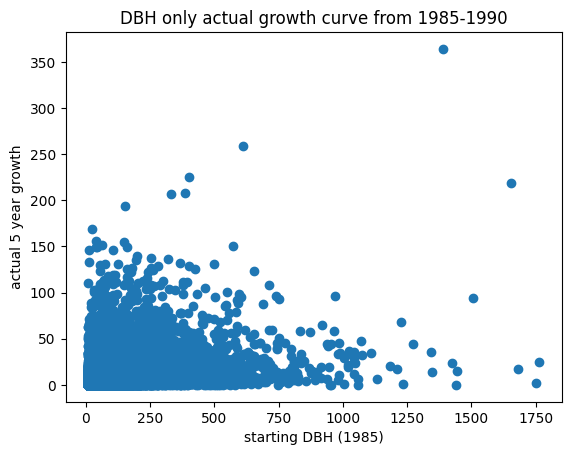

In [63]:
mpl.scatter(X_test1,y_test1)
mpl.title("DBH only actual growth curve from 1985-1990")
mpl.xlabel("starting DBH (1985)")
mpl.ylabel("actual 5 year growth")
mpl.show()

In [29]:
feats2, labels2 = preprocessing.preparedata(feats, labels, sp_num, 2)

#LEVEL TWO!!! DBH AND SPECIES
X_train2, X_test2, y_train2, y_test2 = train_test_split(feats2, labels2, test_size=0.3)
rf2 = RandomForestRegressor(max_depth=3)

rf2.fit(X_train2, y_train2)
preds2 = rf2.predict(X_test2)
error2 = r2_score(y_test2, preds2)
print (error2)

0.19140134292206978


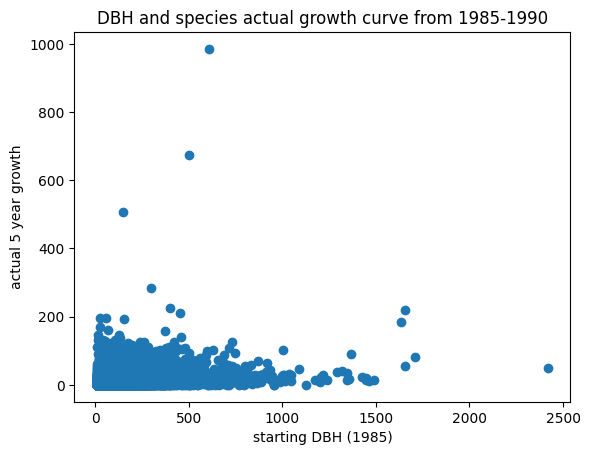

In [30]:
mpl.scatter(X_test2[:,sp_num],y_test2)
mpl.title("DBH and species actual growth curve from 1985-1990")
mpl.xlabel("starting DBH (1985)")
mpl.ylabel("actual 5 year growth")
mpl.show()

In [55]:
importlib.reload(preprocessing)

<module 'preprocessing' from '/Users/dylanvanbramer/indresearch/xu/deep_learning/algorithm_attempts/preprocessing.py'>

In [56]:
feats3, labels3 = preprocessing.preparedata(feats, labels, sp_num, 3)

return


In [ ]:
# draw out structure!!!!

In [54]:
#LEVEL THREE
X_train3, X_test3, y_train3, y_test3 = train_test_split(feats3, labels3, test_size=0.3)
rf3 = RandomForestRegressor(max_depth=3)

#X_train3 = X_train3.reshape(-1,1)
#X_test3 = X_test3.reshape(-1,1)

In [55]:
rf3.fit(X_train3, y_train3)
preds3 = rf3.predict(X_test3)
error3 = r2_score(y_test3, preds3)
print (error3)

0.08156446290320829


fix #get_neighborhood in preprocessing.py

totally good up to there!